- last week we learnt the rolling model
- this week we would learn ensemble methods and intraday trading

In [121]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)

<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [122]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM
## 16

16

In [123]:
product_list = ["btc.usd.td", "eth.usd.td", "btc.usdt", "eth.usdt"]

In [127]:
period = 4096

In [132]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 10959

1059

In [129]:
import dask
from dask import compute, delayed
import sklearn.preprocessing

In [137]:
SAVE_PATH = "e:/intern"
all_dates_x = os.listdir(DATA_PATH + product_list[0])
all_dates_y = os.listdir(DATA_PATH + product_list[1])
all_dates = np.array(list(set(all_dates_x) & set(all_dates_y)))
all_dates.sort()
train_sample = all_dates<"2019-08"
test_sample = all_dates>"2019-08"
date_str = [n[0:10] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])
print(sum(train_sample))
print(sum(test_sample))

122
92


In [138]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
np.append(signal_list, ["ret.4096", "ret.4096.001", "ret.4096.002"])
n_signal = len(signal_list)

In [139]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV,RidgeCV

from sklearn.preprocessing import StandardScaler
#y_signal = "ret."+str(period)+".004"
y_signal = "ret."+str(period)

In [140]:
## get multiple samples of the singal matrix
def get_multiple_sample_signal(good_night_files, sample, product, signal_name, period, daily_num, mod=np.array([0])):
    n_samples = int(sum(daily_num[sample])) ## number of samples
    n_mod = len(mod) ## number of different copies of the same signal
    if n_mod==1: ## if there is one copy then the same as before
        all_signal = np.zeros(n_samples)
    else:
        all_signal = np.zeros((n_mod, n_samples)) ## if there are multiple copies then use a matrix for one signal instead
    cur = 0
    for file in good_night_files[sample]: ## iterate for files
        good = load(SAVE_PATH+"/good pkl/"+product+"/"+file)
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        S = S[good]
        for i in range(n_mod):
            signal = S[(np.arange(len(S))+1) % period == mod[i]]
            ## the ret.cor has some bad records
            signal[np.isnan(signal)] = 0
            signal[np.isinf(signal)] = 0
            if mod[i]==0: 
                cur_end = np.min((cur+len(signal),n_samples)) ## to avoid exceed the number of samoes, mod[i]==0 has most signals, 
                ## so if it doesn't exceed, others would not exceed
            if n_mod==1:
                all_signal[cur:cur_end] = signal[0:(cur_end-cur)]
            else:
                all_signal[i, cur:cur_end] = signal[0:(cur_end-cur)]
        cur = cur_end
    return all_signal

In [141]:
mod = np.arange(0, np.floor(period/10)*10, np.floor(period/10))
n_mod = len(mod)
mod
## array([   0.,  409.,  818., 1227., 1636., 2045., 2454., 2863., 3272.,
##        3681.])

array([   0.,  409.,  818., 1227., 1636., 2045., 2454., 2863., 3272.,
       3681.])

In [142]:
SAVE_PATH = "e:/intern"
os.makedirs(SAVE_PATH+"/train test array", exist_ok=True)

In [145]:
## save the result into a 3-d array, i*j*k, i is for different mod, j*k is the signal matrix for one mod
%time
for product in product_list[0:2]:
    print(product)
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    n_train = sum(daily_num[train_sample])
    n_test = sum(daily_num[test_sample])
    train_array = np.zeros((n_mod, int(n_train), n_signal+1))
    for i in range(n_signal):
        train_array[:,:,i] = get_multiple_sample_signal(all_dates, train_sample, product, signal_list[i], period, daily_num, mod)
    train_array[:,:,n_signal] = get_multiple_sample_signal(all_dates, train_sample, product, "ret."+str(period), period, daily_num, mod)
    save(train_array, SAVE_PATH+"/train test array/"+product+".train.array.pkl")
    
# Wall time: 0 ns
# btc.usd.td
# eth.usd.td



Wall time: 0 ns
btc.usd.td
eth.usd.td


In [146]:
all_train_array = dict([])
for product in product_list[0:2]:
    all_train_array[product] = load(SAVE_PATH+"/train test array/"+product+".train.array.pkl")

In [148]:
## get the result of 10 models
## save them in to a model_coef dictionary
nfold = 10
model_coef = dict([])
for product in product_list[0:2]:
    model_coef[product] = np.zeros(n_signal)
for i_mod in range(n_mod):
    train_std_mat = dict([])
    x_train = np.zeros((0, n_signal))
    y_train = np.array([])
    for product in product_list[0:2]:
        cur_mat = all_train_array[product][i_mod,:,:]
        train_std_mat[product] = np.std(cur_mat, axis=0)
        x_train = np.vstack((x_train, cur_mat[:,:n_signal]/train_std_mat[product][:n_signal]))
        y_train = np.concatenate((y_train, cur_mat[:,n_signal]/train_std_mat[product][n_signal]))
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train)
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(x_train_normal, y_train)
    fit_coef = model.coef_/x_std
    for product in product_list[0:2]:
        coef = fit_coef*train_std_mat[product][n_signal]/train_std_mat[product][:n_signal]
        model_coef[product] = model_coef[product]+coef/n_mod


In [149]:
save(model_coef, SAVE_PATH+"/crypto.ensemble.model.pkl")

In [150]:
 model_coef = load(SAVE_PATH+"/crypto.ensemble.model.pkl")

In [151]:
model_coef

# {'btc.usd.td': array([ 3.74414774e-03,  1.69819332e-03,  2.43481261e-03,  1.01906644e-04,
#         -1.67332801e-01, -3.66836201e-04, -7.85545604e-04,  1.17439080e-04,
#         -5.89936234e-05, -1.77553599e-04, -3.81283207e-06,  2.34160271e-04,
#         -6.05164786e-07,  3.60575996e-05,  9.02326218e-05,  2.34516186e-04,
#          1.00092254e-03, -1.12641384e-05,  3.22550775e-04,  1.29821677e-05,
#         -2.75322068e-04, -2.46528599e-03,  4.26859391e-03, -1.99139132e-03,
#         -1.77006769e-04,  6.71646005e-02, -2.16123902e-04,  9.28407894e-04]),
#  'eth.usd.td': array([ 7.83470383e-03,  3.11290163e-03,  3.48965716e-03,  2.32150080e-04,
#         -1.09818353e-01, -5.75196901e-04, -1.14105738e-03,  2.53406365e-03,
#         -1.80914084e-03, -4.23559189e-03, -8.94887205e-05,  1.25815748e-03,
#         -2.06446756e-05,  8.36919972e-04,  3.07707907e-03,  7.49316669e-03,
#          2.14149378e-02, -1.35487239e-04,  1.47800213e-03,  2.58776727e-04,
#         -5.68231541e-03, -5.77475556e-03,  8.45005994e-03, -2.94451422e-03,
#         -3.55995613e-04,  3.46470317e-02, -3.25974724e-04,  1.43072404e-03])}

{'btc.usd.td': array([ 3.74414774e-03,  1.69819332e-03,  2.43481261e-03,  1.01906644e-04,
        -1.67332801e-01, -3.66836201e-04, -7.85545604e-04,  1.17439080e-04,
        -5.89936234e-05, -1.77553599e-04, -3.81283207e-06,  2.34160271e-04,
        -6.05164786e-07,  3.60575996e-05,  9.02326218e-05,  2.34516186e-04,
         1.00092254e-03, -1.12641384e-05,  3.22550775e-04,  1.29821677e-05,
        -2.75322068e-04, -2.46528599e-03,  4.26859391e-03, -1.99139132e-03,
        -1.77006769e-04,  6.71646005e-02, -2.16123902e-04,  9.28407894e-04]),
 'eth.usd.td': array([ 7.83470383e-03,  3.11290163e-03,  3.48965716e-03,  2.32150080e-04,
        -1.09818353e-01, -5.75196901e-04, -1.14105738e-03,  2.53406365e-03,
        -1.80914084e-03, -4.23559189e-03, -8.94887205e-05,  1.25815748e-03,
        -2.06446756e-05,  8.36919972e-04,  3.07707907e-03,  7.49316669e-03,
         2.14149378e-02, -1.35487239e-04,  1.47800213e-03,  2.58776727e-04,
        -5.68231541e-03, -5.77475556e-03,  8.45005994e-03,

In [152]:
strat = "ensemble.lasso."+str(period)
for product in product_list[0:2]:
    os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [153]:
%%time
for product in product_list[0:2]:
    print(product)
    coef = model_coef[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")

# btc.usd.td
# eth.usd.td
# Wall time: 6min 28s




btc.usd.td
eth.usd.td
Wall time: 6min 28s


In [154]:
%%time
for product in product_list[0:2]:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")

## Wall time: 21.6 s


Wall time: 21.6 s


In [156]:
%%time
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("ensemble.lasso", all_dates, product, 10, 20, CORE_NUM, HEAD_PATH, "e:/intern",
                    period=4096, split_str="2019-08", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)
    
# reverse=1
# reverse=1
# reverse=1
# Wall time: 4min 54s



reverse=1
reverse=1
Wall time: 6min 52s


btc.usd.td train sharpe  1.8383614176674747 test sharpe  1.8968098094114738
eth.usd.td train sharpe  1.8821433511956018 test sharpe  3.8362922077446533
train sharpe:  2.5173105626475962 test sharpe:  2.4037944765392374


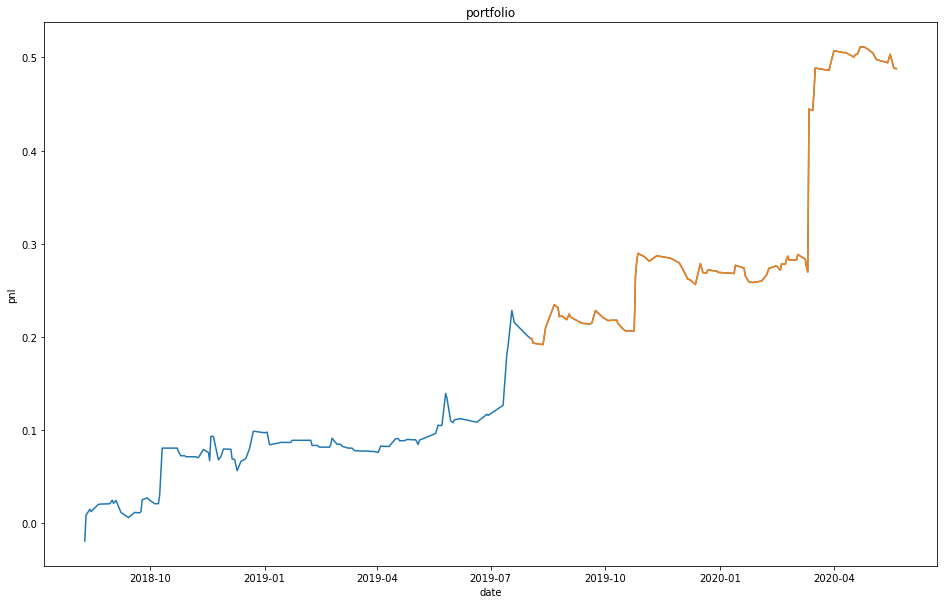

In [157]:
i = 0
strat = "ensemble.lasso.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list[:2])])
train_all_pnl = np.zeros([sum(train_sample), len(product_list[:2])])
min_pnl = 2
min_num = 10
for product in product_list[:2]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    


# btc.usd.td train sharpe  1.8383614176674747 test sharpe  1.8968098094114738
# eth.usd.td train sharpe  1.8821433511956018 test sharpe  3.8362922077446533
# train sharpe:  2.5173105626475962 test sharpe:  2.4037944765392374


- it's not as good as thre model in week 9
- maybe we can use another way of ensemble
- we can generate 10 separate models with each pnl

In [158]:
## generate 10 different models, and save their coefficients rather than calcualte their mean
nfold = 10
model_coef = dict([])
for i_mod in range(n_mod):
    train_std_mat = dict([])
    model_coef[str(i_mod)] = dict([])
    x_train = np.zeros((0, n_signal))
    y_train = np.array([])
    for product in product_list[0:2]:
        cur_mat = all_train_array[product][i_mod,:,:]
        train_std_mat[product] = np.std(cur_mat, axis=0)
        x_train = np.vstack((x_train, cur_mat[:,:n_signal]/train_std_mat[product][:n_signal]))
        y_train = np.concatenate((y_train, cur_mat[:,n_signal]/train_std_mat[product][n_signal]))
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train)
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(x_train_normal, y_train)
    fit_coef = model.coef_/x_std
    for product in product_list[:2]:
        coef = fit_coef*train_std_mat[product][n_signal]/train_std_mat[product][:n_signal]
        model_coef[str(i_mod)][product] = coef


In [160]:
save(model_coef, SAVE_PATH+"crypto.ensemble.all.coef.pkl")

In [163]:
for i_mod in range(n_mod):
    print(i_mod)
    strat = "crypto.ensemble.lasso."+str(i_mod)+"."+str(period)
    for product in product_list[:2]:
        os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
        coef = model_coef[str(i_mod)][product]
        parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
                  product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")
        par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")    
        spread = product_info[product]["spread"]
        tranct = product_info[product]["tranct"]
        tranct_ratio = product_info[product]["tranct.ratio"]
        evaluate_signal("crypto.ensemble.lasso."+str(i_mod), all_dates, product, 2, 20, CORE_NUM, HEAD_PATH, "e:/intern",
                        period=4096, split_str="2019-08", tranct=tranct, 
                        max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)

0
reverse=1
reverse=1
1
reverse=1
reverse=1
2
reverse=1
reverse=1
3
reverse=1
reverse=1
4
reverse=1
reverse=1
5
reverse=1
reverse=1
6
reverse=1
reverse=1
7
reverse=1
reverse=1
8
reverse=1
reverse=1
9
reverse=1
reverse=1


In [167]:
min_pnl = 5
min_num = 10
all_portfolio = np.zeros((sum(test_sample)+sum(train_sample),n_mod))
for i_mod in range(n_mod):
    strat = "crypto.ensemble.lasso."+str(i_mod)+"."+str(period)
    i = 0
    test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
    train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
    for product in product_list[0:2]:
        spread = product_info[product]["spread"]
        signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
        train_stat = signal_stat["train.stat"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_stat = signal_stat["test.stat"]
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
        if sum(good_strat)==0:
            test_pnl = np.zeros(sum(test_sample))
            train_pnl = np.zeros(sum(train_sample))
        test_all_pnl[:,i] = test_pnl
        train_all_pnl[:,i] = train_pnl
        i = i+1
    train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
    test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
    all_portfolio[:,i_mod] = np.append(train_portfolio, test_portfolio)

# btc.usd.td train sharpe  0.29815872719534453 test sharpe  1.8369472285793835
# eth.usd.td train sharpe  1.5211070201592938 test sharpe  3.214419785029105
# btc.usd.td train sharpe  0.017975717854446707 test sharpe  1.109568075269757
# eth.usd.td train sharpe  2.432378123557134 test sharpe  -1.0448736293821752
# btc.usd.td train sharpe  1.2803049916506226 test sharpe  1.5700176519831603
# eth.usd.td train sharpe  1.849391798668616 test sharpe  -1.2360548674706675
# btc.usd.td train sharpe  2.661879008404384 test sharpe  2.247949982267112
# eth.usd.td train sharpe  2.365986169404505 test sharpe  1.824721833087263
# btc.usd.td train sharpe  1.4228989041907145 test sharpe  2.326308487573868
# eth.usd.td train sharpe  2.6729734304898067 test sharpe  2.1500531095074416
# btc.usd.td train sharpe  1.7932635787575664 test sharpe  0.8400705053313451
# eth.usd.td train sharpe  1.8356882579152087 test sharpe  1.8274150687907635
# btc.usd.td train sharpe  0.6022899126243701 test sharpe  -1.7145465257573398
# eth.usd.td train sharpe  1.943422296415979 test sharpe  1.4080066459053164
# btc.usd.td train sharpe  0.9925388160849723 test sharpe  1.4760224541395557
# eth.usd.td train sharpe  1.3024647203899233 test sharpe  0.2313165618832107
# btc.usd.td train sharpe  0.4974995672851375 test sharpe  1.1020689712722247
# eth.usd.td train sharpe  2.043747647496588 test sharpe  -0.9475693068586567
# btc.usd.td train sharpe  1.3126794753610997 test sharpe  1.8846747808196154
# eth.usd.td train sharpe  1.8452072442486034 test sharpe  0.7553837692117019

btc.usd.td train sharpe  0.29815872719534453 test sharpe  1.8369472285793835
eth.usd.td train sharpe  1.5211070201592938 test sharpe  3.214419785029105
btc.usd.td train sharpe  0.017975717854446707 test sharpe  1.109568075269757
eth.usd.td train sharpe  2.432378123557134 test sharpe  -1.0448736293821752
btc.usd.td train sharpe  1.2803049916506226 test sharpe  1.5700176519831603
eth.usd.td train sharpe  1.849391798668616 test sharpe  -1.2360548674706675
btc.usd.td train sharpe  2.661879008404384 test sharpe  2.247949982267112
eth.usd.td train sharpe  2.365986169404505 test sharpe  1.824721833087263
btc.usd.td train sharpe  1.4228989041907145 test sharpe  2.326308487573868
eth.usd.td train sharpe  2.6729734304898067 test sharpe  2.1500531095074416
btc.usd.td train sharpe  1.7932635787575664 test sharpe  0.8400705053313451
eth.usd.td train sharpe  1.8356882579152087 test sharpe  1.8274150687907635
btc.usd.td train sharpe  0.6022899126243701 test sharpe  -1.7145465257573398
eth.usd.td trai

train sharpe:  2.770342247393941 test sharpe:  1.8485429120130399


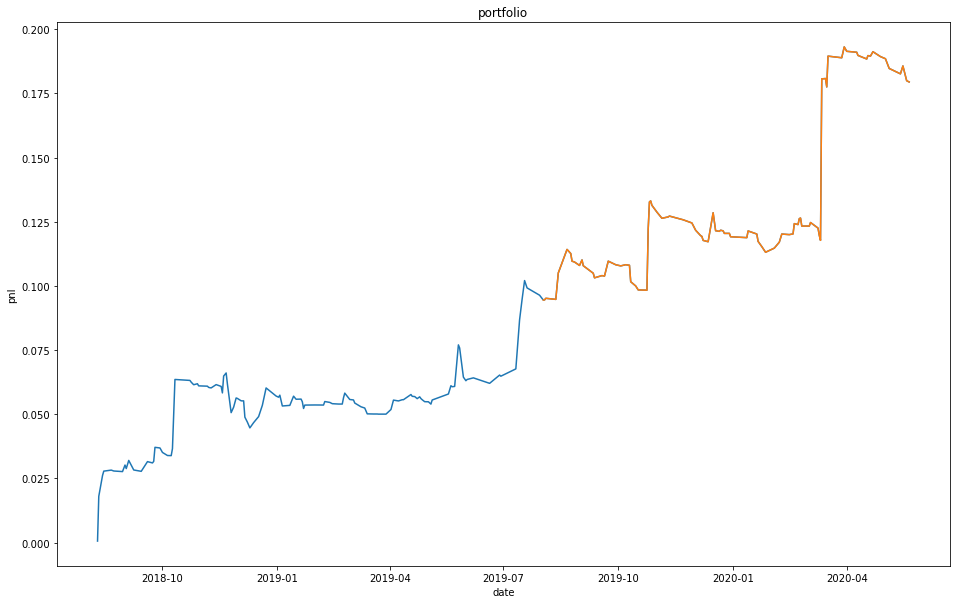

In [168]:
portfolio = np.mean(all_portfolio, axis=1)
train_portfolio = portfolio[train_sample]
test_portfolio = portfolio[test_sample]
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date")
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, portfolio.cumsum());
plt.plot(format_dates[test_sample], portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))   

# train sharpe:  2.770342247393941 test sharpe:  1.8485429120130399


- we can see that the rolling ensemble model much better than train/test


- now we go for the next part: the intraday medium frequency trading

    
- at this time, we do not need to close position every day
- and we cannot use parallel computing for daily pnl because one day's pnl depends on previous position
- but we can still use parallel for each contract because they are independent


- now let's first find the days of each contract

- we know that lasso.4096 is trained using data before 2018
- however our contract is not splited in this way
- so we may need to comply to the data of this format

In [172]:
train_sample_list = dict([])
test_sample_list = dict([])
split_date = "2019-08"
for product in product_list[0:2]:
    medium_train_sample = (all_dates<split_date)
    medium_test_sample = (all_dates>=split_date)
    train_sample_list[product] = medium_train_sample
    test_sample_list[product] = medium_test_sample

In [176]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list[0:2]:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    all_mat[product] = pd.concat((train_mat, test_mat))

In [177]:
y_signal = "ret."+str(period)

In [178]:
train_std = dict([])
all_x_train = dict([])
all_y_train = dict([])
n_sample = 0
for product in product_list[0:2]:
    medium_train_sample = train_sample_list[product]
    medium_test_sample = test_sample_list[product]
    medium_train_range = range(round(sum((daily_ticks[product][medium_train_sample]))))
    medium_test_range = np.arange(sum(daily_ticks[product][medium_train_sample])+1,sum(daily_ticks[product]))
    medium_train_mat = all_mat[product].iloc[medium_train_range,:]
    medium_test_mat = all_mat[product].iloc[medium_test_range,:]
    x_train = medium_train_mat.iloc[:,:n_signal]
    y_train = medium_train_mat[y_signal]
    train_std[product] = np.std(medium_train_mat)
    all_x_train[product] = x_train
    all_y_train[product] = y_train
    n_sample = n_sample+len(y_train)

In [179]:
x_train = np.zeros((n_sample, n_signal))
y_train = np.zeros(n_sample)
cur = 0
for product in product_list[0:2]:
    x_train[cur:(cur+len(all_y_train[product])),] = all_x_train[product]/train_std[product][:n_signal]
    y_train[cur:(cur+len(all_y_train[product]))] = all_y_train[product]/train_std[product][y_signal]
    cur = cur+len(all_y_train[product])

In [180]:
model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(x_train, y_train)
#model = RidgeCV(fit_intercept=False, cv=5).fit(x_train, y_train)
fit_coef = model.coef_
fit_coef

# array([ 2.75673132e-02,  1.01490338e-02,  4.02186908e-02,  0.00000000e+00,
#        -1.06198796e-01,  0.00000000e+00, -0.00000000e+00,  6.32759753e-02,
#        -1.13452943e-02, -0.00000000e+00,  0.00000000e+00,  1.04276528e-01,
#         5.27877194e-03, -6.58194951e-02,  2.11680803e-02,  2.10823793e-04,
#         1.97722801e-01,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
#        -2.27471665e-01, -8.32475270e-03, -0.00000000e+00, -3.05044683e-02,
#        -0.00000000e+00,  3.37073822e-02, -7.33634972e-04, -2.01160142e-02])

array([ 2.75673132e-02,  1.01490338e-02,  4.02186908e-02,  0.00000000e+00,
       -1.06198796e-01,  0.00000000e+00, -0.00000000e+00,  6.32759753e-02,
       -1.13452943e-02, -0.00000000e+00,  0.00000000e+00,  1.04276528e-01,
        5.27877194e-03, -6.58194951e-02,  2.11680803e-02,  2.10823793e-04,
        1.97722801e-01,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -2.27471665e-01, -8.32475270e-03, -0.00000000e+00, -3.05044683e-02,
       -0.00000000e+00,  3.37073822e-02, -7.33634972e-04, -2.01160142e-02])

In [181]:
coef_list=dict([])
for product in product_list[:2]:
    coef = fit_coef*train_std[product][y_signal]/train_std[product][:n_signal]
    coef_list[product] = coef
    print(product)
    print(coef[coef!=0])

# btc.usd.td
# nr.4096                       1.986372e-03
# dbook.4096                    3.152683e-03
# range.pos.4096                2.217752e-03
# ma.dif.10.4096               -1.540382e-01
# nr.range.4096                 9.327746e-05
# dbook.range.4096             -4.800671e-05
# ma.dif.10.range.4096          5.012796e-04
# kdj.k.range.4096              9.604418e-07
# kdj.j.range.4096             -1.386668e-05
# nr.std.4096                   1.132143e-04
# dbook.std.4096                2.923634e-06
# range.pos.std.4096            4.619900e-04
# kdj.j.std.4096               -1.619900e-04
# nr.trend.index.4096          -7.938496e-04
# range.pos.trend.index.4096   -2.773290e-03
# ma.dif.10.trend.index.4096    7.734205e-02
# kdj.k.trend.index.4096       -1.574721e-05
# kdj.j.trend.index.4096       -5.415509e-04
# dtype: float64
# eth.usd.td
# nr.4096                       0.004126
# dbook.4096                    0.005987
# range.pos.4096                0.003311
# ma.dif.10.4096               -0.098646
# nr.range.4096                 0.002348
# dbook.range.4096             -0.001438
# ma.dif.10.range.4096          0.002594
# kdj.k.range.4096              0.000020
# kdj.j.range.4096             -0.000311
# nr.std.4096                   0.002489
# dbook.std.4096                0.000080
# range.pos.std.4096            0.009103
# kdj.j.std.4096               -0.003122
# nr.trend.index.4096          -0.001805
# range.pos.trend.index.4096   -0.004358
# ma.dif.10.trend.index.4096    0.041039
# kdj.k.trend.index.4096       -0.000026
# kdj.j.trend.index.4096       -0.000881
# dtype: float64

btc.usd.td
nr.4096                       1.986372e-03
dbook.4096                    3.152683e-03
range.pos.4096                2.217752e-03
ma.dif.10.4096               -1.540382e-01
nr.range.4096                 9.327746e-05
dbook.range.4096             -4.800671e-05
ma.dif.10.range.4096          5.012796e-04
kdj.k.range.4096              9.604418e-07
kdj.j.range.4096             -1.386668e-05
nr.std.4096                   1.132143e-04
dbook.std.4096                2.923634e-06
range.pos.std.4096            4.619900e-04
kdj.j.std.4096               -1.619900e-04
nr.trend.index.4096          -7.938496e-04
range.pos.trend.index.4096   -2.773290e-03
ma.dif.10.trend.index.4096    7.734205e-02
kdj.k.trend.index.4096       -1.574721e-05
kdj.j.trend.index.4096       -5.415509e-04
dtype: float64
eth.usd.td
nr.4096                       0.004126
dbook.4096                    0.005987
range.pos.4096                0.003311
ma.dif.10.4096               -0.098646
nr.range.4096                 0.0

- here we use ridge because lasso is not good

In [182]:
strat = "crypto.lasso.medium."+str(period)
#strat = "ridge.medium."+str(period)
SAVE_PATH = "e:/intern"

In [183]:
for product in product_list[0:2]:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [184]:
%%time
for product in product_list[0:2]:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern", SAVE_PATH=SAVE_PATH)

# btc.usd.td
# eth.usd.td
# Wall time: 54.3 s



btc.usd.td
eth.usd.td
Wall time: 54.3 s


In [185]:
%%time
for product in product_list[0:2]:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")

#Wall time: 18.7 s

Wall time: 18.7 s


In [186]:
close_thre_list = dict([])
for product in product_list[0:2]:
    all_signal = load(SAVE_PATH+"/all signal/"+product+"."+strat+".pkl")
    open_thre = np.quantile(abs(all_signal), np.concatenate((np.arange(0.991, 0.999, 0.001),
                                                         np.arange(0.9991,0.9999,0.0001)),axis=0))
    thre_mat = pd.DataFrame(data=OrderedDict([("open", open_thre), ("close", -open_thre)]))
    from collections import OrderedDict
    import itertools
    open_list=open_thre
    thre_list = []
    for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
    thre_list = np.array(thre_list)
    close_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
    close_thre_list[product] = close_thre_mat


In [111]:
contract_vec = dict([])
contract_start = dict([])
for product in product_list[0:3]:
    contract_vec[product] = np.array(product_cum[product].index)
    contract_start[product] = np.hstack((0, product_cum[product].values))


In [198]:
## backtest strategy within a contract
## need not to close position at the end of day
## need to get the position at the end of day and calculate the overnight holding pnl
def get_signal_pnl_contract(good_night_files,setName,product, signal_name, thre_mat, 
                                    slippage=1, fee=0.1, reverse=1, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern"):
    file_list = good_night_files
    n_thre = len(thre_mat)
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)
    ## load product info
    tranct = product_info[product]["tranct"]*(1+fee)
    close = product_info[product]["close"]*(1+fee)
    min_spread = product_info[product]["spread"]+0.1
    spread = product_info[product]["spread"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    
    yesterday_pos = np.repeat(0, n_thre)
    yesterday_notional = np.repeat(0., n_thre)
    yesterday_price = 0.
    n_day = len(file_list)
    daily_pnl = np.zeros((n_day, n_thre))
    daily_ret = np.zeros((n_day, n_thre))
    for i_day in range(n_day):
        file = file_list[i_day]
        data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        S = S[data["good"]]
        data = data[data["good"]].reset_index(drop=True)
        n_bar = len(data)
        ## load signal
        ## we don't know the signal is positive correlated or negative correlated  
        pred = S*reverse
        
        bid_ask_spread = data["ask"]-data["bid"]
        data["price"] = (data["ask"]+data["bid"])/2
        next_spread = bid_ask_spread.shift(-1)
        next_spread.iloc[-1] = bid_ask_spread.iloc[-1]
        #not_trade = (data["time"]=="10:15:00") | (data["time"]=="11:30:00") | (data["time"]=="15:00:00") | (bid_ask_spread>min_spread) | (next_spread>min_spread)
        not_trade = ((bid_ask_spread>min_spread) | (next_spread>min_spread))
            
        next_ask = data["next.ask"].values
        next_bid = data["next.bid"].values
          
        i_thre = 0 
        for thre in thre_mat.values:
            buy = pred>thre[0]
            sell = pred<-thre[0]
            signal = pd.Series(data=0, index=data.index)
            #position = signal.copy()
            signal[buy] = 1
            signal[sell] = -1
            signal[not_trade] = 0
            scratch = -thre[1]
            position_pos = pd.Series(data=np.nan, index=data.index)
            position_pos[(signal==1) & (next_ask>0) & (next_bid>0)] = 1
            position_pos[(pred< -scratch) & (next_bid>0)] = 0
            position_pos.iloc[0] = max((0, yesterday_pos[i_thre]))
            position_pos.ffill(inplace=True)
            pre_pos = position_pos.shift(1)
            notional_position_pos = pd.Series(data=np.nan, index=data.index)
            notional_position_pos[position_pos==1] = 1
            notional_position_pos[0] = np.nan
            notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
            notional_position_pos[(notional_position_pos==1)] = 1/data["next.ask"][(notional_position_pos==1)]
            notional_position_pos[(pred< -scratch) & (next_bid>0)] = 0
            notional_position_pos.iloc[0] = max((0, yesterday_notional[i_thre]))
            notional_position_pos.ffill(inplace=True)
            position_neg = pd.Series(data=np.nan, index=data.index)
            position_neg[(signal==-1) & (next_ask>0) & (next_bid>0)] = -1
            position_neg[(pred> scratch) & (next_ask>0)] = 0
            position_neg.iloc[0] = min((yesterday_pos[i_thre], 0))
            position_neg.ffill(inplace=True)
            pre_neg = position_neg.shift(1)
            notional_position_neg = pd.Series(data=np.nan, index=data.index)
            notional_position_neg[position_neg==-1] = -1
            notional_position_neg[0] = np.nan
            notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
            notional_position_neg[(notional_position_neg==-1)] = -1/data["next.bid"][(notional_position_neg==-1)]
            notional_position_neg[(pred> scratch) & (next_ask>0)] = 0
            notional_position_neg.iloc[0] = min((yesterday_notional[i_thre], 0))
            notional_position_neg.ffill(inplace=True)
            position = position_pos + position_neg
            notional_position = notional_position_pos+notional_position_neg
            position.loc[0] = yesterday_pos[i_thre]
            notional_position[0] = yesterday_notional[i_thre]
            if file == file_list[-1]:
                position.iloc[-10:] = 0
                notional_position.iloc[-10:] = 0
            else:
                position.iloc[-10:] = position.iloc[-10]
                notional_position.iloc[-10:] = notional_position.iloc[-10]
            initial_pnl = yesterday_pos[i_thre]*yesterday_price
            initial_notional_pnl = yesterday_notional[i_thre]*yesterday_price
            change_pos = position - position.shift(1)
            change_pos.iloc[0] = 0
            notional_change_pos = notional_position-notional_position.shift(1)
            notional_change_pos.iloc[0] = 0
            pre_pos = position.shift(1)
            pre_pos.iloc[0] = position.iloc[0]
            change_base = pd.Series(data=0, index=data.index)
            change_buy = change_pos>0
            change_sell = change_pos<0
            if (tranct_ratio):
                change_base[change_buy] = (data["next.ask"][change_buy]+spread*slippage)*(1+tranct)
                change_base[change_sell] = (data["next.bid"][change_sell]-spread*slippage)*(1-tranct)
            else:
                change_base[change_buy] = data["next.ask"][change_buy]+tranct+spread*slippage
                change_base[change_sell] = data["next.bid"][change_sell]-tranct-spread*slippage
            notional_change_base = pd.Series(data=0, index=data.index)
            notional_change_buy = notional_change_pos>0
            notional_change_sell = notional_change_pos<0
            if (tranct_ratio):
                notional_change_base[notional_change_buy] = (data["next.ask"][notional_change_buy]+spread*slippage)*(1+tranct)
                notional_change_base[notional_change_sell] = (data["next.bid"][notional_change_sell]-spread*slippage)*(1-tranct)
            else:
                notional_change_base[notional_change_buy] = data["next.ask"][notional_change_buy]+tranct+spread*slippage
                notional_change_base[notional_change_sell] = data["next.bid"][notional_change_sell]-tranct-spread*slippage

            yesterday_pos[i_thre] = position.iloc[-1]
            yesterday_notional[i_thre] = notional_position.iloc[-1]
            final_pnl = -sum(change_base*change_pos)+data["price"].iloc[-1]*yesterday_pos[i_thre]-initial_pnl
            daily_pnl[i_day, i_thre] = final_pnl
            ## add the overnight pnl
            ret = -sum(notional_change_base*notional_change_pos)+data["price"].iloc[-1]*yesterday_notional[i_thre]-initial_notional_pnl
            daily_ret[i_day, i_thre] = ret
            num = sum((position!=0) & (change_pos!=0))
            result.loc[i_thre, ("num")] = result.loc[i_thre, ("num")]+num
            result.loc[i_thre, ("pnl")] = result.loc[i_thre, ("pnl")]+final_pnl
            result.loc[i_thre, ("ret")] = result.loc[i_thre, ("ret")]+ret
            if result.loc[i_thre, ("num")] == 0:
                result.loc[i_thre, ("avg.pnl")] = 0
                result.loc[i_thre, ("avg.ret")] = 0
            else:
                result.loc[i_thre, ("avg.pnl")] = np.divide(result.loc[i_thre, ("pnl")], result.loc[i_thre, ("num")])
                result.loc[i_thre, ("avg.ret")] = np.divide(result.loc[i_thre, ("ret")], result.loc[i_thre, ("num")])
            i_thre = i_thre + 1
        yesterday_price = data["price"].iloc[-1]
    os.makedirs(SAVE_PATH+"/medium strat/"+product+"/"+signal_name, exist_ok=True)
    save((result, daily_pnl, daily_ret), SAVE_PATH+"/medium strat/"+product+"/"+signal_name+"/"+setName+".pkl")

In [201]:
%%time
for product in product_list[0:2]:
    print(product)
    get_signal_pnl_contract(good_night_files=all_dates[train_sample], setName="train", product=product, signal_name=strat, thre_mat=close_thre_list[product]);
    get_signal_pnl_contract(good_night_files=all_dates[test_sample], setName="test", product=product, signal_name=strat, thre_mat=close_thre_list[product]);

# eth.usd.td
# Wall time: 2h 10min 20s


btc.usd.td


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in greater
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in greater
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater
d:\Anacond

eth.usd.td
Wall time: 2h 10min 20s


- then we can select good signals from training samples

In [222]:
train_stat_list = dict([])
for product in product_list[:2]:
    train_stat = OrderedDict([("final.result", None), ("daily.ret", None)])
    (result, daily_pnl, daily_ret) = load(SAVE_PATH+"/medium strat/"+product+"/"+strat+"/"+"train"+".pkl")
    train_stat["final.result"] = result
    train_stat["daily.ret"] = daily_ret
    train_stat_list[product] = train_stat

In [223]:
test_stat_list = dict([])
for product in product_list[:2]:
    test_stat = OrderedDict([("final.result", None), ("daily.ret", None)])
    (result, daily_pnl,daily_ret) = load(SAVE_PATH+"/medium strat/"+product+"/"+strat+"/"+"test"+".pkl")
    test_stat["final.result"] = result
    test_stat["daily.ret"] = daily_ret
    test_stat_list[product] = test_stat

In [225]:
test_stat = test_stat_list[product]
test_pnl = test_stat["daily.ret"][:, good_strat].sum(axis=1)/sum(good_strat)

In [226]:
i = 0
test_all_pnl = np.zeros([sum(test_sample), len(product_list[:2])])
train_all_pnl = np.zeros([sum(train_sample), len(product_list[:2])])
min_pnl = 2
min_num = 10
for product in product_list[:2]:
    spread = product_info[product]["spread"]
    train_stat = train_stat_list[product]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"][:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = test_stat_list[product]
    test_pnl = test_stat["daily.ret"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    i = i+1

# btc.usd.td train sharpe  1.2342050981815362 test sharpe  1.6856276424175733
# eth.usd.td train sharpe  2.6842087489460744 test sharpe  -3.1996005302314083



btc.usd.td train sharpe  1.2342050981815362 test sharpe  1.6856276424175733
eth.usd.td train sharpe  2.6842087489460744 test sharpe  -3.1996005302314083


In [229]:
n_days = len(all_dates)

btc.usd.td train sharpe  1.2342050981815362 test sharpe  1.6856276424175733
eth.usd.td train sharpe  2.6842087489460744 test sharpe  -3.1996005302314083
train sharpe:  2.531483144204246 test sharpe:  0.14570614630466314


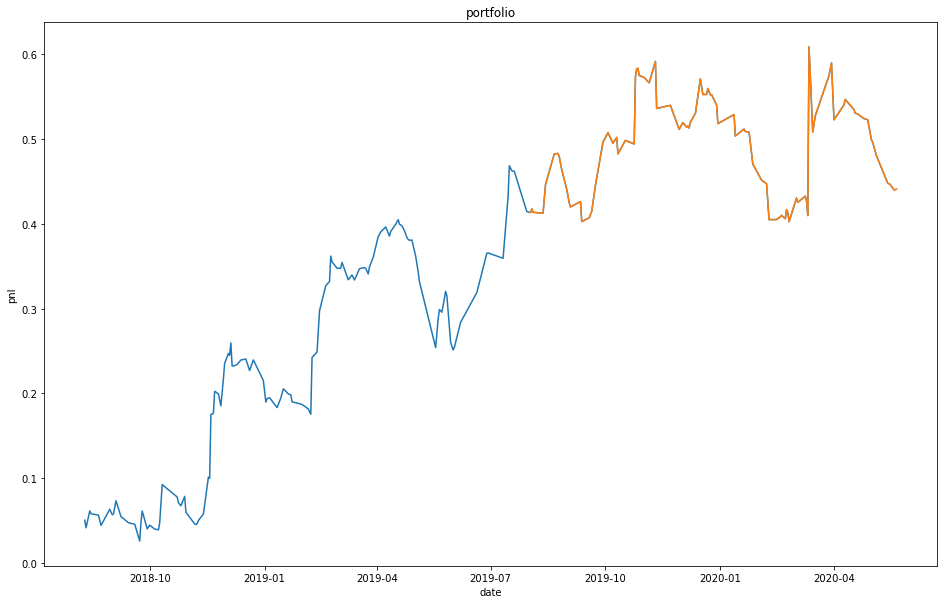

In [230]:
i = 0
all_pnl = np.zeros([n_days, len(product_list[:2])])
min_pnl = 2
min_num = 10
for product in product_list[:2]:
    spread = product_info[product]["spread"]
    train_stat = train_stat_list[product]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"][:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = test_stat_list[product]
    test_pnl = test_stat["daily.ret"][:, good_strat].sum(axis=1)/sum(good_strat)
    all_pnl[:len(train_pnl),i] = train_pnl
    all_pnl[len(train_pnl):n_days,i] = test_pnl
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    i = i+1
all_portfolio = np.array(np.mean(all_pnl, axis=1))
train_portfolio = all_portfolio[train_sample]
test_portfolio = all_portfolio[test_sample]
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    

# btc.usd.td train sharpe  1.2342050981815362 test sharpe  1.6856276424175733
# eth.usd.td train sharpe  2.6842087489460744 test sharpe  -3.1996005302314083
# train sharpe:  2.531483144204246 test sharpe:  0.14570614630466314




- we can see that the test result accpetable even though there is a small drawback
